# BGS Spectral Simulations

The goal of this notebook is to do some BGS spectral simulations for paper one.

## Getting started.

First, import all the package dependencies.

In [57]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import yaml

In [58]:
import desispec.io
import desisim.io
from desisim.scripts import quickgen
from desispec.scripts import group_spectra
from desispec.io.util import write_bintable, makepath

In [59]:
#%pylab inline
from desiutil.log import get_logger
log = get_logger(level='WARNING')

In [60]:
# currently in the bgssim branch of desisim
from desisim.obs import new_exposure

#    new_exposure(flavor, nspec=5000, night=None, expid=None, tileid=None,
#                 airmass=1.0, exptime=None, seed=None, testslit=False,
#                 arc_lines_filename=None, flat_spectrum_filename=None,
#                 target_densities = {})
#    returns :   fibermap, truth

# or

# wavelengths = qsim.source.wavelength_out.to(u.Angstrom).value
# bgs = desisim.templates.BGS(wave=wavelengths, add_SNeIa=args.add_SNeIa)
# flux, tmpwave, meta1 = bgs.make_templates(nmodel=nobj, seed=args.seed, zrange=args.zrange_bgs,
#                    rmagrange=args.rmagrange_bgs,sne_rfluxratiorange=args.sne_rfluxratiorange)

## Specify the parameters of the simulation.

Next, let's specify the number and spectral type distribution of spectra we want to simulate, and the random seed.  Setting the seed here (which can be any number at all!) ensures that your simulations are reproducible.  Let's also explicitly set the *night* of the "observations" (the default is to use the current date) and the *expid* or exposure ID number (which would allow you to simulate more than one DESI exposure).

The *flavor* option is used to choose the correct sky-brightness model and it also determines the distribution of targets for a given flavor.  For example, *flavor='dark'* returns the right relative sampling density of ELGs, LRGs, and QSOs.  The other available (science target) options for *flavor* are 'dark', 'gray', 'grey', 'bright', 'bgs', 'mws', 'lrg', 'elg', 'qso', and 'std'.  (You can also set flavor to either 'arc' or 'flat' but that would be boring!)

In [61]:
nspec = 200
seed = 555
night = '20170701'
flavor = 'bgs'
nexp = 10 # number of exposures

#### Define the range of allowable observational conditions ####

In [62]:
exptime_range = (300, 300)
airmass_range = (1.25, 1.25)
moonphase_range = (0.0, 1.0)
moonangle_range = (0, 150)
moonzenith_range = (0, 60)

#### Define the survey and targeting values for density, sky coverage, etc
Any parameters you wish to set to the default can simply be commented out below,
the code only replaces the keys that are defined

In [63]:
targ_dens = {}
targ_dens['frac_std'] =  0.02
targ_dens['frac_sky'] =  0.08

targ_dens['area'] =  14000.0

targ_dens['area_bgs'] =  14000
targ_dens['nobs_bgs_bright'] =  762
targ_dens['nobs_bgs_faint'] =  475
targ_dens['ntarget_bgs_bright'] =  818
targ_dens['ntarget_bgs_faint'] =  618
targ_dens['success_bgs_bright'] =  0.97
targ_dens['success_bgs_faint'] =  0.92

targ_dens['nobs_mws'] =  700
targ_dens['ntarget_mws'] =  736
targ_dens['success_mws'] =  0.99

## Check our environment variables

In [64]:
def check_env():
    for env in ('DESIMODEL', 'DESI_ROOT', 'DESI_SPECTRO_SIM', 'DESI_SPECTRO_DATA', 
            'DESI_SPECTRO_REDUX', 'SPECPROD', 'PIXPROD','DESI_BASIS_TEMPLATES'):
        if env in os.environ:
            print('{} environment set to {}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))

In [65]:
check_env()

DESIMODEL environment set to /global/common/edison/contrib/desi/code/desimodel/0.7.0
DESI_ROOT environment set to /global/project/projectdirs/desi
DESI_SPECTRO_SIM environment set to /global/project/projectdirs/desi/spectro/sim
DESI_SPECTRO_DATA environment set to /global/project/projectdirs/desi/spectro/sim/bgs-specsim-paper-kr/
DESI_SPECTRO_REDUX environment set to /global/project/projectdirs/desi/spectro/redux
SPECPROD environment set to bgs-specsim-paper-kr
PIXPROD environment set to bgs-specsim-paper-kr
DESI_BASIS_TEMPLATES environment set to /project/projectdirs/desi/spectro/templates/basis_templates/trunk


In [66]:
%set_env SPECPROD=bgs-specsim-paper-kr
%set_env PIXPROD=bgs-specsim-paper-kr
rawdata_dir = desisim.io.simdir()
%set_env DESI_SPECTRO_DATA=$rawdata_dir
%set_env DESI_BASIS_TEMPLATES=/project/projectdirs/desi/spectro/templates/basis_templates/trunk

print('Simulated raw data will be written to {}'.format(desisim.io.simdir()))
print('Pipeline will read raw data from {}'.format(desispec.io.rawdata_root()))
print('    (without knowing that it was simulated)')
print('Pipeline will write processed data to {}'.format(desispec.io.specprod_root()))

env: SPECPROD=bgs-specsim-paper-kr
env: PIXPROD=bgs-specsim-paper-kr
env: DESI_SPECTRO_DATA=/global/project/projectdirs/desi/spectro/sim/bgs-specsim-paper-kr/
env: DESI_BASIS_TEMPLATES=/project/projectdirs/desi/spectro/templates/basis_templates/trunk
Simulated raw data will be written to /global/project/projectdirs/desi/spectro/sim/bgs-specsim-paper-kr/
Pipeline will read raw data from /global/project/projectdirs/desi/spectro/sim/bgs-specsim-paper-kr/
    (without knowing that it was simulated)
Pipeline will write processed data to /global/project/projectdirs/desi/spectro/redux/bgs-specsim-paper-kr


## Generate the random conditions: ##
given the conditions specified above
#### Set the random state with the seed given

In [67]:
rand = np.random.RandomState(seed)

#### Randomly select observing consitions for each exposure

In [68]:
expids = np.arange(nexp).astype(int)
exptime = rand.uniform(exptime_range[0], exptime_range[1], nexp)
airmass = rand.uniform(airmass_range[0], airmass_range[1], nexp)
moonphase = rand.uniform(moonphase_range[0], moonphase_range[1], nexp)
moonangle = rand.uniform(moonangle_range[0], moonangle_range[1], nexp)
moonzenith = rand.uniform(moonzenith_range[0], moonzenith_range[1], nexp)

#### Build a metadata table with the top-level simulation inputs.

In [69]:
metafile = os.path.join( desisim.io.simdir(), 'mysim.fits')
metacols = [
    ('BRICKNAME', 'S20'),
    ('SEED', 'S20'),
    ('EXPTIME', 'f4'),
    ('AIRMASS', 'f4'),
    ('MOONPHASE', 'f4'),
    ('MOONANGLE', 'f4'),
    ('MOONZENITH', 'f4')]
meta = Table(np.zeros(nexp, dtype=metacols))
meta['EXPTIME'].unit = 's'
meta['MOONANGLE'].unit = 'deg'
meta['MOONZENITH'].unit = 'deg'

#meta['BRICKNAME'] = ['{}-{:03d}'.format(args.brickname, ii) for ii in range(args.nbrick)]
meta['EXPTIME'] = exptime
meta['AIRMASS'] = airmass
meta['MOONPHASE'] = moonphase
meta['MOONANGLE'] = moonangle
meta['MOONZENITH'] = moonzenith

log.info('Writing {}'.format(metafile))

#### Open yaml to define the targeting parameter values ####
Then for those defined above in targ_dens, change the default value to what we specified

In [70]:
targetyaml = os.path.join(os.environ['DESIMODEL'],'data','targets','targets.yaml')
tgt = yaml.load(open(targetyaml))
for key, val in targ_dens.items():
    tgt[key] = val


## Generating noiseless *simspec* and *fibermap* spectral files ##

The first step is to generate the `fibermap` and `simspec` files needed by `quickgen`.  The `fibermap` table contains (simulated) information about the position of each target in the DESI focal plane, while the `simspec` table holds the "truth" spectra and the intrinsic properties of each object (redshift, noiseless photometry, [OII] flux, etc.).

In detail, the *simspec* and *fibermap* data models are described at  
* http://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_SIM/PIXPROD/NIGHT/simspec-EXPID.html
* http://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_DATA/NIGHT/fibermap-EXPID.html



In [ ]:
for ii,expid in enumerate(expids):
    fibermap, truth = new_exposure(flavor, nspec=nspec, night=night, expid=int(expid), tileid=None,\
                 airmass=airmass[ii], exptime=exptime[ii], seed=seed,\
                 target_densities=tgt)

## Simulate spectra using `quickgen` ##
To get around the fact that we aren't using the command line, we use the arg parser
and pass the arguments to the main function of quickgen directly.

more information at:
http://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/PRODNAME/exposures/NIGHT/EXPID/index.html

`Quickgen` additional commands for 'quickbrick mode:'
    '--objtype', 'BGS',
    '--brickname', 'whatever',
    '--zrange-bgs', (0.01, 0.4),
    '--rmagrange-bgs', (15.0,19.5)
    '--exptime', None
   '--airmass', 1.5

In [ ]:
for ii,expid in enumerate(expids):
    fiberfile = desispec.io.findfile('fibermap', night=night, expid=expid)
    simspecfile = desisim.io.findfile('simspec', night=night, expid=expid)
    args = quickgen.parse([
                            '--simspec', simspecfile,
                            '--fibermap', fiberfile,
                            '--nspec', str(nspec),
                            '--seed', str(seed),
                            '--moon-phase', str(moonphase[ii]),
                            '--moon-angle', str(moonangle[ii]),
                            '--moon-zenith', str(moonzenith[ii])
          ])
    quickgen.main(args)
    

## Regroup the spectra ##

working with `cframe` files is pretty tedious, especially across three cameras, 10 spectrographs, and more than 35 million targets!  Therefore, let's combine and reorganize the individual `cframe` files into `spectra` files grouped on the sky. Spectra are organized into healpix pixels (here chosen to have `nside=64`).  If you're interested, you can read more about the healpix directory structure here:  
https://github.com/desihub/desispec/blob/master/doc/nb/Intro_to_DESI_spectra.ipynb

Regrouping is especially important for real observations with overlapping tiles where the same object could be reobserved on different exposures separated by short or large amounts of time.


In [86]:
nside = 64
args = group_spectra.parse(['--hpxnside', '{}'.format(nside)])
group_spectra.main(args)

Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x2aab07a58598>
Traceback (most recent call last):
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/weakref.py", line 109, in remove
    def remove(wr, selfref=ref(self)):
KeyboardInterrupt
Process ForkPoolWorker-426:
Process ForkPoolWorker-415:
Process ForkPoolWorker-423:
Process ForkPoolWorker-429:
Process ForkPoolWorker-400:
Process ForkPoolWorker-433:
Process ForkPoolWorker-434:
Process ForkPoolWorker-401:
Process ForkPoolWorker-425:
Process ForkPoolWorker-431:
Process ForkPoolWorker-406:
Process ForkPoolWorker-407:
Process ForkPoolWorker-435:
Process ForkPoolWorker-408:
Process ForkPoolWorker-412:
Process ForkPoolWorker-432:
Process ForkPoolWorker-417:
Process ForkPoolWorker-403:
Process ForkPoolWorker-421:
Process ForkPoolWorker-402:
Process ForkPoolWorker-410:
Process ForkPoolWorker-405:
Process ForkPoolWorker-397:
Process ForkPoolWorker-404:
Proces

  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/process.py", li

  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/pool.py

  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  Fi

KeyboardInterrupt: 

  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self.

  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/global/common/edison/contrib/desi/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/global/common/edison/contr

## Looking at the fibermap and spectral metadata ##

First, let's see what got written to the raw data directory as a result of that last command.

In [101]:
#rawdata_dir = desispec.io.rawdata_root()
#!find $rawdata_dir | sort

read the *fibermap* and *simspec* files from on-disk.

In [102]:
#fiberfile = desispec.io.findfile('fibermap', night=night, expid=expid)
#simspecfile = desisim.io.findfile('simspec', night=night, expid=expid)

In [115]:
print('Reading fibermap file {}'.format(fiberfile))
hdu = fits.open(fiberfile)
#hdu.info()
fibermap = Table(hdu['FIBERMAP'].data)
hdu.close()
print('Reading simspec file {}.'.format(simspecfile))
hdu = fits.open(simspecfile)
#hdu.info()
meta = Table(hdu['METADATA'].data)
hdu.close()
#print(meta.colnames)


Reading fibermap file /global/project/projectdirs/desi/spectro/sim/bgs-specsim-paper-kr/20170701/fibermap-00000009.fits
Reading simspec file /global/project/projectdirs/desi/spectro/sim/bgs-specsim-paper-kr/20170701/simspec-00000009.fits.


#### Make a simple plot

Here's a fun simple plot of the redshift histogram distributions.  Now you try!

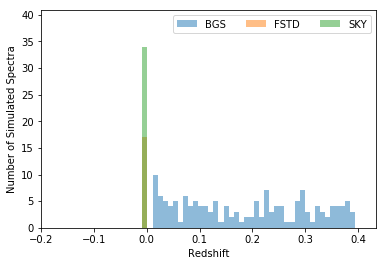

In [116]:
allobjtype = meta['OBJTYPE']
redlim = (-0.2, 1.1*meta['REDSHIFT'].max())
fig, ax = plt.subplots()
for objtype in sorted(set(allobjtype)):
    indx = objtype == allobjtype
    hh = ax.hist(meta['REDSHIFT'][indx], bins=nspec//3, 
                 label=objtype, alpha=0.5, range=redlim)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of Simulated Spectra')
ax.legend(loc='upper right', ncol=3)
ax.margins(0.2)
ax.set_xlim(redlim)
plt.show()

# Looking at the `quickgen` Simulated Spectra #

#### Inspect the output cframe files ####

Let's briefly look at one of the `cframe` files for the blue camera using `desispec.io.frame.read_frame`, which returns a `Frame` class with all the attributes you might want.

In [117]:
cframefile = desispec.io.findfile('cframe', night=night, expid=expid, camera='b0')
print('Reading {}'.format(cframefile))
cframe = desispec.io.frame.read_frame(cframefile)

Reading /global/project/projectdirs/desi/spectro/redux/bgs-specsim-paper-kr/exposures/20170701/00000009/cframe-b0-00000009.fits


In [106]:
#dir(cframe)

Let's make a quick plot of the zeroth spectrum.

In [118]:
print(cframe.wave.shape, cframe.flux.shape)

(4760,) (200, 4760)


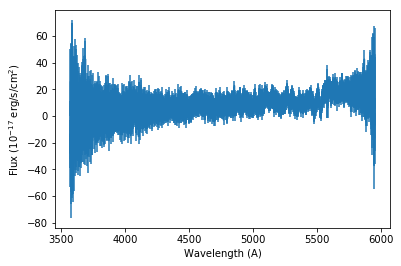

In [119]:
fig, ax = plt.subplots()
ax.errorbar(cframe.wave, cframe.flux[0, :], 1/np.sqrt(cframe.ivar[0, :]))
ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Flux ($10^{-17}$ erg/s/cm$^2$)')
plt.show()

## Looking at regrouped spectra ##


#### Inspect the output (combined and regrouped) spectra ####

So what did we end up with in the redux output directory?
* `exposures/{night}/{expid}/`: individual spectrograph camera spectra ("frames")
  grouped by night/expid
* `spectra-64/`: spectra grouped by healpix location on the sky

In [120]:
reduxdir = desispec.io.specprod_root()
!find $reduxdir | sort

/global/project/projectdirs/desi/spectro/redux/bgs-specsim-paper-kr
/global/project/projectdirs/desi/spectro/redux/bgs-specsim-paper-kr/exposures
/global/project/projectdirs/desi/spectro/redux/bgs-specsim-paper-kr/exposures/20170701
/global/project/projectdirs/desi/spectro/redux/bgs-specsim-paper-kr/exposures/20170701/00000000
/global/project/projectdirs/desi/spectro/redux/bgs-specsim-paper-kr/exposures/20170701/00000000/calib-b0-00000000.fits
/global/project/projectdirs/desi/spectro/redux/bgs-specsim-paper-kr/exposures/20170701/00000000/calib-r0-00000000.fits
/global/project/projectdirs/desi/spectro/redux/bgs-specsim-paper-kr/exposures/20170701/00000000/calib-z0-00000000.fits
/global/project/projectdirs/desi/spectro/redux/bgs-specsim-paper-kr/exposures/20170701/00000000/cframe-b0-00000000.fits
/global/project/projectdirs/desi/spectro/redux/bgs-specsim-paper-kr/exposures/20170701/00000000/cframe-r0-00000000.fits
/global/project/projectdirs/desi/spectro/redux/bgs-specsim-paper-kr/exposu

As a quick example, let's plot up the zeroth spectrum in healpix pixel `12637`.

In [121]:
specfilename = desispec.io.findfile('spectra', groupname=12637, nside=nside)

In [122]:
print('Reading {}'.format(specfilename))
specobj = desispec.io.read_spectra(specfilename)

Reading /global/project/projectdirs/desi/spectro/redux/bgs-specsim-paper-kr/spectra-64/126/12637/spectra-64-12637.fits


In [112]:
#dir(specobj)

In [123]:
specobj.wave.keys(), specobj.flux.keys()

(dict_keys(['z', 'r', 'b']), dict_keys(['z', 'r', 'b']))

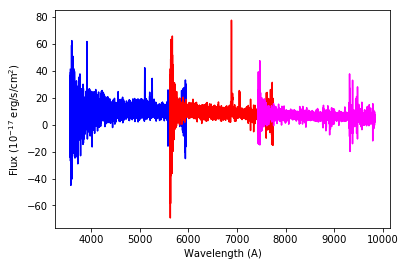

In [124]:
thisone = 0
fig, ax = plt.subplots()
for camera, color in zip( ('b', 'r', 'z'), ('blue', 'red', 'magenta') ):
    ax.plot(specobj.wave[camera], specobj.flux[camera][thisone], color=color)
ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Flux ($10^{-17}$ erg/s/cm$^2$)')
plt.show()
plt.close()